In [1]:
# Benchmark models

# Code sourced from the following:
# https://www.kaggle.com/crawford/resize-and-save-images-as-numpy-arrays-128x128/notebook
# https://www.kaggle.com/crawford/lung-infiltration-cnn-with-keras-on-chest-x-rays/code
# https://www.kaggle.com/raoulma/cancer-image-tensorflow-cnn-80-valid-acc/notebook


import cv2
import os
import random
import matplotlib.pylab as plt
import matplotlib.cm as cm  
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import datetime
import seaborn as sns
from scipy import interp
from itertools import cycle

%matplotlib inline

In [2]:
# ../input/
PATH = os.path.abspath(os.path.join('..', 'Margaret'))

# ../input/sample/images/
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Load labels
labels = pd.read_csv('../Margaret/sample_labels.csv')

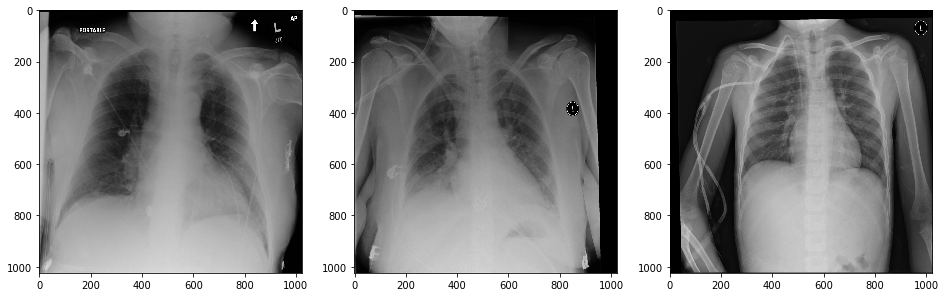

In [3]:
#show random samples

r = random.sample(images, 5)
r

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[1]))

plt.subplot(132)
plt.imshow(cv2.imread(r[2]))

plt.subplot(133)
plt.imshow(cv2.imread(r[0])); 

In [4]:
images[0:10]

['C:\\Users\\Margaret\\sample\\images\\00000013_005.png',
 'C:\\Users\\Margaret\\sample\\images\\00000013_026.png',
 'C:\\Users\\Margaret\\sample\\images\\00000017_001.png',
 'C:\\Users\\Margaret\\sample\\images\\00000030_001.png',
 'C:\\Users\\Margaret\\sample\\images\\00000032_001.png',
 'C:\\Users\\Margaret\\sample\\images\\00000040_003.png',
 'C:\\Users\\Margaret\\sample\\images\\00000042_002.png',
 'C:\\Users\\Margaret\\sample\\images\\00000057_001.png',
 'C:\\Users\\Margaret\\sample\\images\\00000061_002.png',
 'C:\\Users\\Margaret\\sample\\images\\00000061_019.png']

In [5]:
labels[1:10]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


In [6]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    disease="No Finding"

    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 128
    HEIGHT = 128

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

        # Labels
        if disease in finding:
            finding = str(disease)
            finding = 0
            y.append(finding)

        else:
            #finding = "Not_" + str(disease)
            finding = 1
            y.append(finding)

    return x,y

In [7]:
x,y = proc_images()

In [8]:
print(y[1:10])

[1, 0, 1, 1, 1, 0, 0, 1, 0]


In [9]:
df = pd.DataFrame()
df["labels"]=y
df["images"]=x

print(len(df), df.images[0].shape)

5606 (128, 128, 3)


In [10]:
np.savez("x_images_arrays", x)
np.savez("y_coded_labels", y)

In [11]:
# Load npz file containing image arrays
x_npz = np.load("../Margaret/x_images_arrays.npz")
x = x_npz['arr_0']

# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load("../Margaret/y_coded_labels.npz")
y = y_npz['arr_0']

In [12]:
# First split the data in two sets, 80% for training, 20% for test)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
#x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [13]:
print(np.array(x_train).shape)
#print(np.array(x_val).shape)
print(np.array(x_test).shape)
print(np.array(y_train).shape)
#print(np.array(y_val).shape)
print(np.array(y_test).shape)

(4484, 128, 128, 3)
(1122, 128, 128, 3)
(4484,)
(1122,)


In [14]:
# function to normalize data
def normalize_data_train(data): 
        data_train = (x_train-x_train.mean())/(x_train.std()) # standardisation
        return data_train

# function to normalize data
#def normalize_data_val(data_val): 
    # scale features using statistics that are robust to outliers
    # rs = sklearn.preprocessing.RobustScaler()
    # rs.fit(data)
    # data = rs.transform(data)
    #data_val = (x_val-x_train.mean())/(x_train.std()) # standardisation
    # data = data / data.max() # convert from [0:255] to [0.:1.]
    # data = ((data / 255.)-0.5)*2. # convert from [0:255] to [-1.:+1.]
    #return data_val

# function to normalize data
def normalize_data_test(data_test): 
        data_test = (x_test-x_train.mean())/(x_train.std()) # standardisation
        return data_test

In [15]:
# Note renaming
x_train_norm = normalize_data_train(x_train)
# x_val_norm = normalize_data_val(x_val)
x_test_norm = normalize_data_test(x_test)


# dictionaries for saving results
y_val_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, val_loss = {}, {}
train_acc, val_acc = {}, {}
cnf_val_matrix = {}

In [16]:
print('x_train_norm.shape =', x_train_norm.shape)
print('x_train_norm.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_train_norm.min(),
                        x_train_norm.mean(), x_train_norm.std(), x_train_norm.max()))
print('y_train.shape =', y_train.shape)
print('y_train.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train.min(),
                        y_train.mean(), y_train.std(), y_train.max()))

print('')
print('x_test_norm.shape =', x_test_norm.shape)
print('x_test_norm.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_test_norm.min(),
                        x_test_norm.mean(), x_test_norm.std(), x_test_norm.max()))

print('y_test_norm.shape =', y_test.shape)
print('y_test_norm.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_test.min(),
                        y_test.mean(), y_test.std(), y_test.max()))

x_train_norm.shape = (4484, 128, 128, 3)
x_train_norm.min/mean/std/max = -1.99/0.00/1.00/2.01
y_train.shape = (4484,)
y_train.min/mean/std/max = 0.00/0.46/0.50/1.00

x_test_norm.shape = (1122, 128, 128, 3)
x_test_norm.min/mean/std/max = -1.99/0.01/1.00/2.01
y_test_norm.shape = (1122,)
y_test_norm.min/mean/std/max = 0.00/0.46/0.50/1.00


In [17]:
# First try out some sklearn models

# compute the accuracy of label predictions
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

# store models in dictionary
#base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               #'random_forest': random_forest, 'decision_tree': decision_tree, 
               #'gaussianNB': gaussianNB}

# choose models for out-of-folds predictions
#take_models = ['logreg', 'random_forest', 'extra_trees', 'gaussianNB']

#for mn in base_models:
    #train_acc[mn] = []
    #val_acc[mn] = []
    #cnf_val_matrix[mn] = []

In [ ]:
for mn in base_models:
    # create cloned model from base models
    model = sklearn.base.clone(base_models[mn])
    model.fit(x_train, y_train)
    
    # predictions
    y_train_pred[mn] = model.predict(x_train)
    y_val_pred[mn] = model.predict(x_valid)
    
    
    # accuracies
    train_acc[mn].append(accuracy_from_dense_labels(y_train_pred[mn],
                         y_train))
    val_acc[mn].append(accuracy_from_dense_labels(y_val_pred[mn], 
                         y_val))
    
    # normalized confusion matrix
    cnf_valid_matrix_tmp = sklearn.metrics.confusion_matrix(
        y_pred = y_val_pred[mn], 
        y_true = y_val).astype(np.float32)
    cnf_valid_matrix_tmp[0,:] = cnf_valid_matrix_tmp[0,:]/cnf_valid_matrix_tmp[0,:].sum()
    cnf_valid_matrix_tmp[1,:] = cnf_valid_matrix_tmp[1,:]/cnf_valid_matrix_tmp[1,:].sum()
    cnf_val_matrix[mn].append(cnf_valid_matrix_tmp)

print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[mn][-1],
                                                         val_acc[mn][-1]))

print('running time for training: ', datetime.datetime.now() - start)
print('')
for mn in train_acc.keys():
    print(mn + ' : averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                              np.mean(val_acc[mn])))

In [19]:
# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
       
# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True) #, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_norm)):

    # start timer
    #start = datetime.datetime.now();
    
    # reshape datasets
    x_train_cv = x_train_norm[train_index].reshape(-1,49152)
    y_train_cv = y_train[train_index]
    x_valid_cv = x_train_norm[valid_index].reshape(-1,49152)
    y_valid_cv = y_train[valid_index]

12-05-2018 14:40:30 : start training


In [20]:
print(x_train_cv.shape)
print(y_train_cv.shape)
print("")
print(x_valid_cv.shape)
print(y_valid_cv.shape)

(4036, 49152)
(4036,)

(448, 49152)
(448,)


In [25]:
# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# logistic regression
from sklearn.model_selection import cross_val_score
x_train_log = x_train_norm.reshape(-1,49152)

logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs') # removed multiclass setting
logreg1 = logreg.fit(x_train_log, y_train)
print(cross_val_score(logreg1, x_train_log, y_train, cv=10))


12-05-2018 14:49:50 : start training
[ 0.55233853  0.58129176  0.59020045  0.60356347  0.56347439  0.60044643
  0.57589286  0.53348214  0.58928571  0.57718121]


In [27]:
print(__doc__)

Automatically created module for IPython interactive environment


12-05-2018 14:53:51 : start training


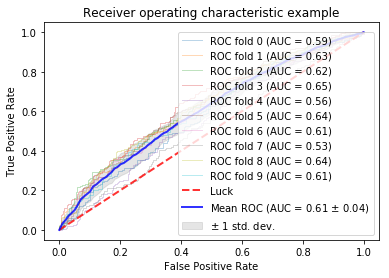

In [28]:
# Classification and ROC analysis

# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# Logistic Regression

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
logreg2 = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs') 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x_train_log, y_train):
    probas_ = logreg2.fit(x_train_log[train], y_train[train]).predict_proba(x_train_log[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

12-05-2018 14:59:26 : start training


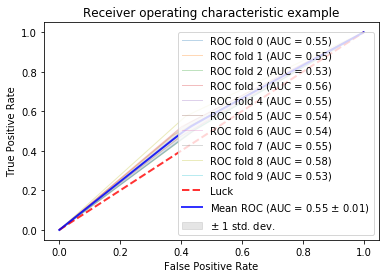

In [29]:
# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# decision_tree = sklearn.tree.DecisionTreeClassifier()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
dt = sklearn.tree.DecisionTreeClassifier() 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x_train_log, y_train):
    probas_ = dt.fit(x_train_log[train], y_train[train]).predict_proba(x_train_log[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


12-05-2018 15:44:44 : start training


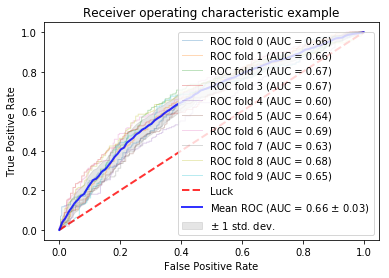

In [30]:
# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0, max_depth=4)

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
et = sklearn.ensemble.ExtraTreesClassifier(verbose=0, max_depth=4) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x_train_log, y_train):
    probas_ = et.fit(x_train_log[train], y_train[train]).predict_proba(x_train_log[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

13-05-2018 13:17:57 : start training


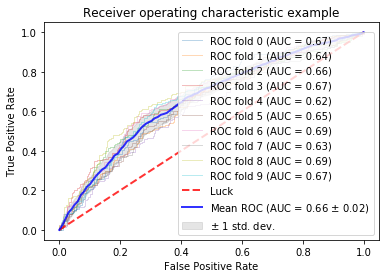

In [35]:
# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose=0)

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
gb = sklearn.ensemble.GradientBoostingClassifier(verbose=0) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x_train_log, y_train):
    probas_ = gb.fit(x_train_log[train], y_train[train]).predict_proba(x_train_log[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

13-05-2018 18:13:14 : start training


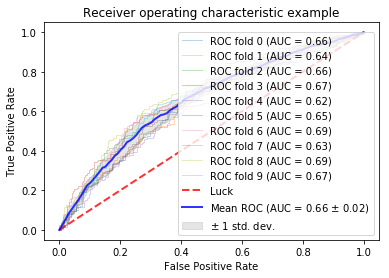

In [36]:
# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0, max_depth=4, n_estimators=10)

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
rf = sklearn.ensemble.GradientBoostingClassifier(verbose=0) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x_train_log, y_train):
    probas_ = rf.fit(x_train_log[train], y_train[train]).predict_proba(x_train_log[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

13-05-2018 12:33:04 : start training


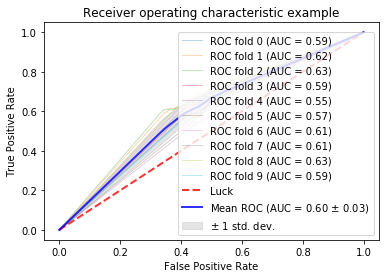

In [34]:
# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# gaussianNB = sklearn.naive_bayes.GaussianNB()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
gnb = sklearn.naive_bayes.GaussianNB() 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x_train_log, y_train):
    probas_ = gnb.fit(x_train_log[train], y_train[train]).predict_proba(x_train_log[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()